In [1]:
import torch
import numpy as np
import os
import sys
sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import seed_everything
seed_everything(0)
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline
import pathlib


/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


coco

In [2]:
path_csv = '../data/coco'

from collections import defaultdict, Counter
class_num = defaultdict(int)
with open(path_csv + '/data/train_anno.json') as f:
  adj = np.zeros((80,80))
  import json
  train = json.load(f)
  print(len(train), train[0])

  li = []
  gt_labels = np.zeros((len(train),80))
  img_id2idx = dict()
  idx2img_id = []
  for i,each in enumerate(train):
    li += each['labels']
    gt_labels[i, each['labels']] = 1
    for l in each['labels']:
      class_num[l] += 1

  nums = gt_labels.sum(axis=0)
  adj = []
  for i,col in enumerate(gt_labels.T):
    if i in [34]:
      print(i)
      selected = gt_labels[np.isin(col, [1.0]), :]
      nonzero_cnt = (selected != 0).sum(1)
      cnter = Counter(nonzero_cnt)
      print(cnter)
    cond_prob = gt_labels[np.isin(col,[1.0]),:].sum(axis=0)
    cond_prob[i] = 0
    adj.append(cond_prob)
    # print(adj[-1])
  nums = nums.tolist()
  nums.sort()
  nums.reverse()
  # nums = reversed(nums)
  print(max(nums), min(nums))
  di={'adj': np.asarray(adj), "nums": np.asarray(nums)}
  class_di = {k: v for k, v in sorted(class_num.items(), key=lambda item: item[1], reverse=True)} #sorted
print(class_di.keys(), class_di.values())

82081 {'file_name': 'COCO_train2014_000000057870.jpg', 'labels': [12, 77, 51, 22, 27]}
34
Counter({1: 1234, 2: 407, 3: 116, 4: 27, 5: 8, 8: 3, 7: 2, 6: 1})
45174.0 128.0
dict_keys([49, 22, 18, 27, 26, 13, 14, 36, 74, 2, 8, 12, 21, 57, 75, 24, 23, 41, 51, 28, 62, 72, 20, 16, 76, 68, 7, 32, 77, 58, 61, 42, 73, 44, 67, 65, 70, 9, 0, 10, 59, 50, 53, 11, 17, 37, 47, 5, 4, 34, 78, 52, 54, 64, 40, 3, 30, 33, 66, 39, 25, 15, 79, 45, 46, 63, 31, 19, 1, 60, 56, 43, 29, 38, 71, 55, 6, 48, 69, 35]) dict_values([45174, 8950, 8606, 8378, 6518, 5968, 5028, 4861, 4321, 3924, 3844, 3734, 3322, 3291, 3191, 3170, 3159, 3097, 3084, 3041, 2986, 2893, 2818, 2791, 2749, 2667, 2539, 2537, 2530, 2511, 2493, 2475, 2464, 2442, 2368, 2343, 2317, 2287, 2243, 2241, 2209, 2202, 2180, 2098, 2080, 2068, 2003, 1884, 1804, 1798, 1771, 1671, 1645, 1631, 1625, 1618, 1518, 1511, 1510, 1471, 1389, 1340, 1324, 1290, 1216, 1214, 1205, 1186, 1171, 1170, 1105, 1089, 1062, 821, 700, 673, 668, 481, 151, 128])


In [3]:
test_dataset = COCO2014('../data/coco', phase='val')
# partial=torch.utils.data.Subset(test_dataset, list(range(100)))
# train_dataset = Voc2007Classification('data/voc', 'trainval', inp_name='data/voc/voc_glove_word2vec.pkl', LT=True)
# test_dataset = Voc2007Classification('data/voc', 'test', inp_name='data/voc/voc_glove_word2vec.pkl')
# train_dataset = COCO2014('data/coco', phase='train', inp_name='data/coco/coco_glove_word2vec.pkl')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
test_dataset.transform = transforms.Compose([
                Warp(384),
                transforms.ToTensor(),
                normalize,
            ])

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)
from util import AveragePrecisionMeter
AP = AveragePrecisionMeter(difficult_examples=False)



[dataset] Done!
[annotation] Done!
[json] Done!


In [4]:
from backbones.config import config
print(config)
for k, v in config.items():
  print("{} : {}".format(k, v))
  pathlib.Path('../figures/{}'.format(k)).mkdir(parents=True, exist_ok=True) 

{'resnet50': 'resnetv2_50x3_bitm_in21k', 'swin': 'swin_base_patch4_window12_384_in22k', 'swin_large': 'swin_large_patch4_window12_384_in22k', 'convnext': 'convnext_large_in22k', 'resnet101': 'resnetv2_101x1_bitm_in21k'}
resnet50 : resnetv2_50x3_bitm_in21k
swin : swin_base_patch4_window12_384_in22k
swin_large : swin_large_patch4_window12_384_in22k
convnext : convnext_large_in22k
resnet101 : resnetv2_101x1_bitm_in21k


In [5]:
from models import *
from backbones.config import config
import pathlib

# model = base_swin(config['swin_large'], 80, image_size=384, pretrained=True, cond=True, where=0, aggregate='1')
model = base_resnet101(config['resnet101'], 80, 384, cond=False)
# path = '../checkpoint/coco/coco_l_alpha-@0_swin_large_base_best.pth.tar'
# path ='../checkpoint/coco/coco_squeeze-excitation-noscale_resnet101_base_best.pth.tar'
path ='../checkpoint/coco/coco_baseline-scheduler_resnet101_base_best.pth.tar'
# path ='../checkpoint/coco/coco_baseline_swin_large_base_best.pth.tar'
# path = '../checkpoint/coco/coco_l_alpha@2_swin_base_best.pth.tar'
di = torch.load(path)
print(di['best_score'])
print(di.keys())
model.load_state_dict(di['state_dict'])


{'mAP': tensor(77.5326), 'OF1': 0.7472008685789622, 'CF1': 0.7163356289242881}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])


<All keys matched successfully>

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = get_model(i).to(device)
model = model.to(device)
model = model.eval()
act_li = np.array([[]])
for i, (input, target) in tqdm(enumerate(test_loader)):
  img, path = input
  target[target == 0] = 1
  target[target == -1] = 0
  feat_Var = torch.autograd.Variable(img).float().to(device)
  
  # output = model(feat_Var, None).detach()
  output = model(feat_Var)
  # act_li = np.append(act_li, act_.detach().cpu().numpy())
  # print(act_li.shape)
  # print(output.requires_grad, target.requires_grad)
  # print(output.shape, target.shape)
  AP.add(output.detach(), target)

# map = 100 * AP.value().mean()
# print(100 * AP.value())
# ap_li = 100 * AP.value()
print(AP.scores.shape)

402it [07:56,  1.19s/it]

torch.Size([40137, 80])


In [7]:
m_name="resnet101"
act_li = act_li.squeeze()
with open('../figures/{}/act.npy'.format(m_name), 'wb') as f:
    np.save(f, act_li)
with open('../figures/{}/apscore.npy'.format(m_name), 'wb') as f:
    np.save(f, AP.scores)
with open('../figures/{}/apvalue.npy'.format(m_name), 'wb') as f:
    np.save(f, 100*AP.value())
with open('../figures/{}/aptarget.npy'.format(m_name), 'wb') as f:
    np.save(f, AP.targets)



Sorted instance score and alpha for correlation

In [8]:
import json
with open('../data/coco/data/category.json', 'r') as f:
  category = json.load(f)
  # category["banana"]
  inverse = {v:k for k, v in category.items()}

inverse[0]

'airplane'

In [9]:
m_name='resnet101'
act_li = np.load('../figures/{}/act.npy'.format(m_name))
sc_li = np.load('../figures/{}/scale.npy'.format(m_name))
AP = AveragePrecisionMeter()
AP.scores = torch.from_numpy(np.load('../figures/{}/apscore.npy'.format(m_name)))
AP.targets = torch.from_numpy(np.load('../figures/{}/aptarget.npy'.format(m_name)))
print(AP.scores.shape)

torch.Size([40137, 80])


In [15]:
act_li[0]

3.1019209423277516e-10

In [13]:

for i in range(AP.scores.shape[1]):##iterate each class
  classwise = dict({"alpha":[], "score":[], "target": [],})
  score = AP.scores[:,i]
  target = AP.targets[:, i]

  #filter
  # true_indices = torch.where(target == 0)

  score_true = score[:]
  # print(act_li.shape)
  act_li_ = act_li[:]
  # sc_li = sc_li[true_indices]
  # print(torch.where(target==1))
  
  # dataset_true = [test_dataset[each] for each in torch.where(target == 0)[0].tolist()]
  sorted, indices = torch.sort(score_true, dim=0, descending=True)
  #sort with indices
  act_li_sorted = act_li_[indices]
  target_sorted = target[indices]
  # sc_li = sc_li[indices]
  
  print(score_true.shape)
  # classwise["class_index"].append(i)
  classwise["alpha"] = act_li_sorted
  # classwise["scale"] = sc_li
  classwise["score"] = sorted
  classwise["target"] = target_sorted

  

  img_df = pd.DataFrame(data=classwise)
  img_df.to_csv("../figures/{}/class[{}]_alpha_scale.csv".format(m_name, inverse[i]))

torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])
torch.Size([40137])


In [21]:
# path="../figures/swin_large/class[hair drier]_alpha_scale.csv"

# df = pd.read_csv(path)
# alpha_t = df.loc[df['target'] == 1, 'alpha']
# print(alpha_t.describe())
# alpha_f = df.loc[df['target'] == 0, 'alpha']
# print(alpha_f.describe())
import json
alpha = []
with open('../data/coco/data/category.json', 'r') as f:
  category = json.load(f)
  # category["banana"]
  inverse = {v:k for k, v in category.items()}

  for k, v in category.items():
    print(k, v)
    path="../figures/{}/class[{}]_alpha_scale.csv".format(m_name, k)

    df = pd.read_csv(path)
    alpha_t = df.loc[df['target'] == 1, 'alpha']
    # alpha_t.to_csv("../figures/{}/classTrue[{}]_alpha_scale.csv".format(m_name, k))
    # print(alpha_t.head())
    # print(alpha_t.describe())
    print(alpha_t.mean())
    alpha.append(alpha_t.mean())
assert len(alpha)==80

df = pd.DataFrame({"class": list(category.keys()), "scale": alpha})
df.to_csv("../figures/{}/scale_per_class.csv".format(m_name))

airplane 0
5.498907522542262e-10
apple 1
6.920669054628442e-10
backpack 2
2.801790062385225e-10
banana 3
9.093362790569722e-10
baseball bat 4
2.5002124388942674e-10
baseball glove 5
4.453509341567757e-10
bear 6
5.059171937585699e-10
bed 7
2.6569708435206567e-10
bench 8
3.081108868245264e-10
bicycle 9
2.8175873721531776e-10
bird 10
6.117529668519332e-10
boat 11
2.460995226434826e-10
book 12
3.9940347817880133e-10
bottle 13
4.78547125900088e-10
bowl 14
4.4949341733706056e-10
broccoli 15
6.066898441233776e-10
bus 16
3.927031625712871e-10
cake 17
3.9111739819898957e-10
car 18
3.276663789967908e-10
carrot 19
5.602432664839102e-10
cat 20
3.0745145277802835e-10
cell phone 21
5.661163264166701e-10
chair 22
3.8106094611621106e-10
clock 23
4.585826845931195e-10
couch 24
3.629689059984913e-10
cow 25
4.0831192922133573e-10
cup 26
4.891896463266558e-10
dining table 27
4.238717782421446e-10
dog 28
2.6112951538276456e-10
donut 29
3.6342002982562273e-10
elephant 30
2.348335032871143e-10
fire hydrant 3

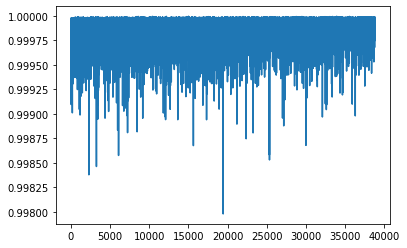

In [31]:
import matplotlib.pyplot as plt

df = pd.read_csv('../figures/{}/classFalse[bed]_alpha_scale.csv'.format(m_name))['alpha']

df.plot()

plt.show()

Best3 and Worst3 performing classes

In [32]:
classwise_img = dict({"class_index":[], "1":[], "2":[], "3":[], "-1":[], "-2":[], "-3":[]})
for i in range(AP.scores.shape[1]):
  score = AP.scores[:,i]
  target = AP.targets[:, i]
  score_true = score[torch.where(target == 1)]
  # print(torch.where(target==1))
  
  dataset_true = [test_dataset[each] for each in torch.where(target == 1)[0].tolist()]
  sorted, indices = torch.sort(score_true, dim=0, descending=True)
  
  print(score_true.shape)
  classwise_img["class_index"].append(i)
  classwise_img["1"].append(dataset_true[int(indices[0])][0][1])
  classwise_img["2"].append(dataset_true[int(indices[1])][0][1])
  classwise_img["3"].append(dataset_true[int(indices[2])][0][1])
  classwise_img["-1"].append(dataset_true[int(indices[-1])][0][1])
  classwise_img["-2"].append(dataset_true[int(indices[-2])][0][1])
  classwise_img["-3"].append(dataset_true[int(indices[-3])][0][1])
  
classwise_img
img_df = pd.DataFrame(data=classwise_img)
img_df.to_csv("../figures/{}/topandworst.csv".format(m_name))

torch.Size([840])
torch.Size([491])
torch.Size([1832])
torch.Size([728])
torch.Size([799])
torch.Size([845])
torch.Size([341])
torch.Size([1292])
torch.Size([1961])
torch.Size([1114])
torch.Size([1121])
torch.Size([1048])
torch.Size([1828])
torch.Size([2912])
torch.Size([2397])
torch.Size([670])
torch.Size([1350])
torch.Size([969])
torch.Size([4180])
torch.Size([578])
torch.Size([1480])
torch.Size([1695])
torch.Size([4404])
torch.Size([1704])
torch.Size([1448])
torch.Size([666])
torch.Size([3061])
torch.Size([3960])
torch.Size([1521])
torch.Size([523])
torch.Size([714])
torch.Size([592])
torch.Size([1173])
torch.Size([757])
torch.Size([849])
torch.Size([70])
torch.Size([2272])
torch.Size([1001])
torch.Size([452])
torch.Size([750])
torch.Size([727])
torch.Size([1410])
torch.Size([1232])
torch.Size([512])
torch.Size([1219])
torch.Size([674])
torch.Size([568])
torch.Size([989])
torch.Size([261])
torch.Size([21634])
torch.Size([1117])
torch.Size([1540])
torch.Size([790])
torch.Size([1041])

In [33]:
plt.rcParams.update({'font.size': 8})
for row_idx, row in img_df.iterrows():
  fig = plt.figure(figsize=(12, 12))
  for idx, (j, item) in enumerate(row.iteritems()):
    if j == "class_index":
      continue
    a = fig.add_subplot(2, 3, idx)
    img_id = '/home/seongha/LT-ML/data/coco/data/val2014/{}'.format(item)
    image = Image.open(img_id)  
    imgplot = plt.imshow(image)
    # a.axis("off")
    # a.set_title(names[i].split('(')[0], fontsize=30)
  
  plt.savefig('../figures/{}/topandworst_class_{}.png'.format(m_name, row_idx), bbox_inches='tight', dpi=100)

/tmp/ipykernel_101283/2526294419.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


# Classwise AP

In [9]:
label_li = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']#voc
label_li = list(class_di.keys()) #coco
ap_li = 100 * AP.value()

### sorted class wise ap

In [13]:
m_name='resnet101'

In [14]:
data_ = {"class_index": list(class_di.keys()),
"class_size": list(class_di.values()),
"AP": ap_li}

df = pd.DataFrame(data=data_)
df.to_csv("../figures/{}/sorted_ap_baseline{}.csv".format(m_name, m_name))
df.reset_index()

,index,class_index,class_size,AP
0,0,49,45174,96.732132
1,1,22,8950,67.002098
2,2,18,8606,40.081284
3,3,27,8378,80.071243
4,4,26,6518,95.650810
...,...,...,...,...
75,75,55,673,80.927071
76,76,6,668,76.382812
77,77,48,481,70.343414
78,78,69,151,68.259087


### label distribution csv

In [4]:
m_name = 'convnext'
df = pd.read_csv("../figures/{}/sorted_ap_{}.csv".format(m_name, m_name))

In [7]:

top = df.nlargest(8, 'AP')
print(top)
data_ = []
for i, j in zip(top.class_index, top.index):
  print(i)
  col = gt_labels[:, i]
  selected = gt_labels[np.isin(col, [1.0]), :]
  nonzero_cnt = (selected != 0).sum(1)
  cnter = Counter(nonzero_cnt)
  print(cnter)
  cnter = dict(sorted(cnter.items(),key = lambda i: i[0]))
  cnter['class_index'] = i
  cnter['rank'] = j
  data_.append(cnter)
df_top5 = pd.DataFrame(data=data_)
df_top5 = df_top5.fillna(0)
df_top5 = df_top5.set_index(['class_index', 'rank'])
df_top5.to_csv("../figures/{}/label_distribution_top_{}.csv".format(m_name, m_name))

worst = df.nsmallest(8, 'AP')
data_ = []
for i, j in zip(worst.class_index, worst.index):
  print(i)
  col = gt_labels[:, i]
  selected = gt_labels[np.isin(col, [1.0]), :]
  nonzero_cnt = (selected != 0).sum(1)
  cnter = Counter(nonzero_cnt)
  print(cnter)
  cnter = dict(sorted(cnter.items(),key = lambda i: i[0]))
  cnter['class_index'] = i
  cnter['rank'] = j
  data_.append(cnter)
df_worst5 = pd.DataFrame(data=data_)
df_worst5 = df_worst5.fillna(0)
df_worst5 = df_worst5.set_index(['class_index', 'rank'])
df_worst5.to_csv("../figures/{}/label_distribution_worst_{}.csv".format(m_name, m_name))

    Unnamed: 0  class_index  class_size         AP
67          67           19        1186  97.547930
49          49           34        1798  97.169050
34          34           67        2368  96.780850
30          30           61        2493  95.840400
79          79           35         128  94.742190
73          73           38         821  93.922264
0            0           49       45174  93.445090
6            6           14        5028  92.356060
19
Counter({3: 290, 4: 239, 2: 210, 5: 160, 6: 88, 7: 67, 1: 36, 8: 31, 9: 28, 11: 14, 10: 12, 12: 9, 13: 1, 14: 1})
34
Counter({1: 1234, 2: 407, 3: 116, 4: 27, 5: 8, 8: 3, 7: 2, 6: 1})
67
Counter({3: 1083, 2: 688, 4: 388, 5: 146, 6: 44, 7: 9, 1: 4, 9: 3, 8: 2, 11: 1})
61
Counter({6: 395, 7: 375, 5: 352, 4: 346, 8: 267, 3: 219, 9: 179, 10: 110, 2: 85, 11: 81, 12: 45, 13: 20, 14: 8, 15: 5, 1: 4, 16: 2})
35
Counter({3: 42, 4: 27, 5: 22, 2: 17, 6: 10, 7: 3, 8: 3, 1: 3, 10: 1})
38
Counter({2: 209, 3: 181, 4: 126, 1: 81, 5: 75, 6: 66, 7: 38

stacked histogram